In [109]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle, ConnectionPatch
from matplotlib.collections import PatchCollection
import matplotlib as mpl
plt.style.use(["ggplot", "../.default.mplstyle"])

from matplotlib import rc
rc('text', usetex=False)

In [2]:
import traceback
import numpy as np
import pandas as pd
import GPy
import scipy

import aggregate
import objective
import aquisition
import distribution
import modeler
from parameter import Space, Builder
from distribution import TruncNormal


from functools import reduce
from operator import mul

In [3]:
%matplotlib inline

In [4]:
o = objective.Schwefel(d=1, invert=True)
x = o.sample_space(1000)

f = o(x)

pn = x.shape[0]

In [5]:
mus = [Space(np.linspace(l + 0.05*(h-l), h-0.05*(h-l), 50))
       for l, h in o.range]

mus = [Space(np.linspace(l, h, 50))
       for l, h in o.range]

low = min([l for l, h in o.range])
hi = max([h for l, h in o.range])
d = hi-low
u = .1
l = .01

std = Space(np.logspace(np.log10(l*d), np.log10(u*d), 5))

spc = reduce(mul, mus) * std

b = Builder(spc)
# register normal for each input dim, last column is std
for i in range(x.shape[1]):
    def bld(m, s, ii=i): return TruncNormal(m, s, *o.range[ii])
    b.register(bld, [i, x.shape[1]])


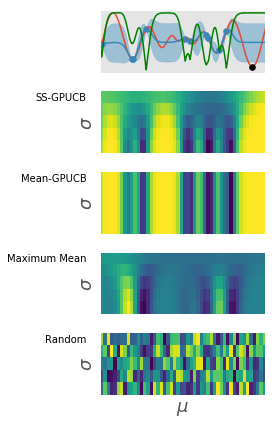

In [73]:
n = 10
scipy.random.seed(5)
xi = np.random.choice(np.arange(pn), n, replace=False)
# x = o.sample_space(pn)[np.random.choice(np.arange(pn), n, replace=False)]
mx = x[xi]
y = o(mx)[:, None]

builder = modeler.Modeler(o, noiseless=True, kernel=GPy.kern.RBF(x.shape[1], ARD=False))

m = builder.build(mx, y, resample=2)

mu, var = m.predict(builder.transform(x))
mu = mu[:, 0]
var = var[:, 0]

nmu = mu * y.std() + y.mean()
nvar = var * y.var()

a = aquisition.SBUCB_LocalPenalty(sample_size=3)
a._precompute(m, builder, x, mu, var, False, n, pn)
alpha = - mu + a.beta(mx.shape[0], x.shape[0]) * np.sqrt(var)

plt.figure(figsize=(4, 6))

plt.subplot(5, 1, 1)
plt.plot(x, f, zorder=1, label="$f$")
plt.scatter(o.optimum, o(o.optimum), marker="o", c="k", zorder=2, label='$x^*$')
plt.yticks([])

plt.plot(x, nmu, label="approximiation of $f$")
plt.fill_between(x[:,0], nmu-2*np.sqrt(nvar), nmu+2*np.sqrt(nvar), alpha=.4, color="C1")
plt.scatter(mx, y, c="C1", label="observations")

plt.twinx()
plt.plot(x[:,0], alpha, color='green', label="aquisition")
plt.yticks([])
plt.grid(False)

plt.xlim(-500, 500)
plt.xticks([])

for i, (nm, ac) in enumerate([
    ("SS-GPUCB", aquisition.SBUCB_LocalPenalty),
    ("Mean-GPUCB", aquisition.Mean),
    ("Maximum Mean", aquisition.MaxMean),
    ("Random", aquisition.Random)
]):
    a = ac(sample_size=1)
    a._precompute(m, builder, x, mu, var, True, n, pn)
    acq = a.compute(m, builder, x, b, True, n, pn)
    
    plt.subplot(5, 1, i+2)
    plt.imshow(acq.reshape((50, 5)).T, origin="bottom", aspect="auto")
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.ylabel("$\sigma$")
    plt.text(-4.5, 3.7, nm, horizontalalignment="right")

plt.xlabel("$\mu$")
    
plt.tight_layout()

plt.savefig("figures/acquisition-compare-early-sequential.pdf", bbox_inches="tight")

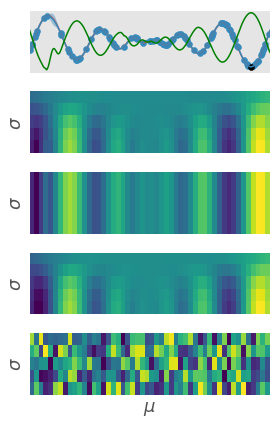

In [74]:
n = 100
scipy.random.seed(5)
xi = np.random.choice(np.arange(pn), n, replace=False)
# x = o.sample_space(pn)[np.random.choice(np.arange(pn), n, replace=False)]
mx = x[xi]
y = o(mx)[:, None]

builder = modeler.Modeler(o, noiseless=True, kernel=GPy.kern.RBF(x.shape[1], ARD=False))

m = builder.build(mx, y, resample=2)

mu, var = m.predict(builder.transform(x))
mu = mu[:, 0]
var = var[:, 0]

nmu = mu * y.std() + y.mean()
nvar = var * y.var()

a = aquisition.SBUCB_LocalPenalty(sample_size=3)
a._precompute(m, builder, x, mu, var, False, n, pn)
alpha = - mu + a.beta(mx.shape[0], x.shape[0]) * np.sqrt(var)

plt.figure(figsize=(4, 6))

plt.subplot(5, 1, 1)
plt.plot(x, f, zorder=1, label="$f$")
plt.scatter(o.optimum, o(o.optimum), marker="o", c="k", zorder=2, label='$x^*$')
plt.yticks([])

plt.plot(x, nmu, label="approximiation of $f$")
plt.fill_between(x[:,0], nmu-2*np.sqrt(nvar), nmu+2*np.sqrt(nvar), alpha=.4, color="C1")
plt.scatter(mx, y, c="C1", label="observations")

plt.twinx()
plt.plot(x[:,0], alpha, color='green', label="aquisition")
plt.yticks([])
plt.grid(False)

plt.xlim(-500, 500)
plt.xticks([])

for i, (nm, ac) in enumerate([
    ("SS-GPUCB", aquisition.SBUCB_LocalPenalty),
    ("Mean-GPUCB", aquisition.Mean),
    ("Maximum Mean", aquisition.MaxMean),
    ("Random", aquisition.Random)
]):
    a = ac(sample_size=1)
    a._precompute(m, builder, x, mu, var, True, n, pn)
    acq = a.compute(m, builder, x, b, True, n, pn)
    
    plt.subplot(5, 1, i+2)
    plt.imshow(acq.reshape((50, 5)).T, origin="bottom", aspect="auto")
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.ylabel("$\sigma$")

plt.xlabel("$\mu$")
    
plt.tight_layout()

plt.savefig("figures/acquisition-compare-late-sequential.pdf", bbox_inches="tight")

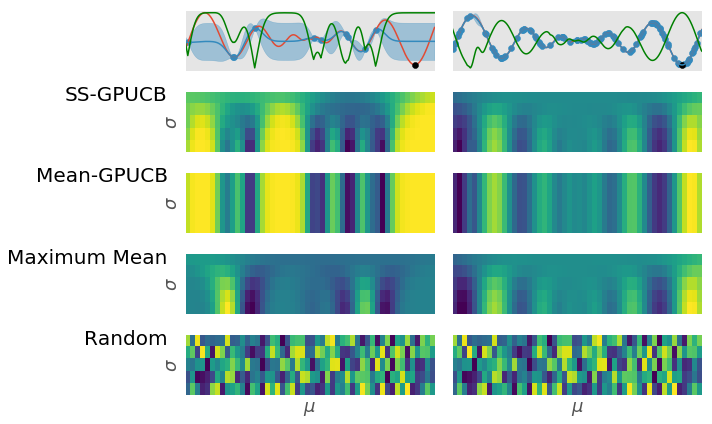

In [81]:
n = 10
scipy.random.seed(5)
xi = np.random.choice(np.arange(pn), n, replace=False)
# x = o.sample_space(pn)[np.random.choice(np.arange(pn), n, replace=False)]
mx = x[xi]
y = o(mx)[:, None]

builder = modeler.Modeler(o, noiseless=True, kernel=GPy.kern.RBF(x.shape[1], ARD=False))

m = builder.build(mx, y, resample=2)

mu, var = m.predict(builder.transform(x))
mu = mu[:, 0]
var = var[:, 0]

nmu = mu * y.std() + y.mean()
nvar = var * y.var()

a = aquisition.SBUCB_LocalPenalty(sample_size=3)
a._precompute(m, builder, x, mu, var, False, n, pn)
alpha = - mu + a.beta(mx.shape[0], x.shape[0]) * np.sqrt(var)

plt.figure(figsize=(10, 6))

plt.subplot(5, 2, 1)
plt.plot(x, f, zorder=1, label="$f$")
plt.scatter(o.optimum, o(o.optimum), marker="o", c="k", zorder=2, label='$x^*$')
plt.yticks([])

plt.plot(x, nmu, label="approximiation of $f$")
plt.fill_between(x[:,0], nmu-2*np.sqrt(nvar), nmu+2*np.sqrt(nvar), alpha=.4, color="C1")
plt.scatter(mx, y, c="C1", label="observations")

plt.twinx()
plt.plot(x[:,0], alpha, color='green', label="aquisition")
plt.yticks([])
plt.grid(False)

plt.xlim(-500, 500)
plt.xticks([])

for i, (nm, ac) in enumerate([
    ("SS-GPUCB", aquisition.SBUCB_LocalPenalty),
    ("Mean-GPUCB", aquisition.Mean),
    ("Maximum Mean", aquisition.MaxMean),
    ("Random", aquisition.Random)
]):
    a = ac(sample_size=1)
    a._precompute(m, builder, x, mu, var, True, n, pn)
    acq = a.compute(m, builder, x, b, True, n, pn)
    
    plt.subplot(5, 2, i*2+3)
    plt.imshow(acq.reshape((50, 5)).T, origin="bottom", aspect="auto")
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.ylabel("$\sigma$")
    plt.text(-4, 3.7, nm, horizontalalignment="right",fontsize=20)

plt.xlabel("$\mu$")

n = 100
scipy.random.seed(5)
xi = np.random.choice(np.arange(pn), n, replace=False)
# x = o.sample_space(pn)[np.random.choice(np.arange(pn), n, replace=False)]
mx = x[xi]
y = o(mx)[:, None]

builder = modeler.Modeler(o, noiseless=True, kernel=GPy.kern.RBF(x.shape[1], ARD=False))

m = builder.build(mx, y, resample=2)

mu, var = m.predict(builder.transform(x))
mu = mu[:, 0]
var = var[:, 0]

nmu = mu * y.std() + y.mean()
nvar = var * y.var()

a = aquisition.SBUCB_LocalPenalty(sample_size=3)
a._precompute(m, builder, x, mu, var, False, n, pn)
alpha = - mu + a.beta(mx.shape[0], x.shape[0]) * np.sqrt(var)

plt.subplot(5, 2, 2)
plt.plot(x, f, zorder=1, label="$f$")
plt.scatter(o.optimum, o(o.optimum), marker="o", c="k", zorder=2, label='$x^*$')
plt.yticks([])

plt.plot(x, nmu, label="approximiation of $f$")
plt.fill_between(x[:,0], nmu-2*np.sqrt(nvar), nmu+2*np.sqrt(nvar), alpha=.4, color="C1")
plt.scatter(mx, y, c="C1", label="observations")

plt.twinx()
plt.plot(x[:,0], alpha, color='green', label="aquisition")
plt.yticks([])
plt.grid(False)

plt.xlim(-500, 500)
plt.xticks([])

for i, (nm, ac) in enumerate([
    ("SS-GPUCB", aquisition.SBUCB_LocalPenalty),
    ("Mean-GPUCB", aquisition.Mean),
    ("Maximum Mean", aquisition.MaxMean),
    ("Random", aquisition.Random)
]):
    a = ac(sample_size=1)
    a._precompute(m, builder, x, mu, var, True, n, pn)
    acq = a.compute(m, builder, x, b, True, n, pn)
    
    plt.subplot(5, 2, i*2+4)
    plt.imshow(acq.reshape((50, 5)).T, origin="bottom", aspect="auto")
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

plt.xlabel("$\mu$")
    
plt.tight_layout()

plt.savefig("figures/acquisition-compare-sequential.pdf", bbox_inches="tight")

# batch

## early

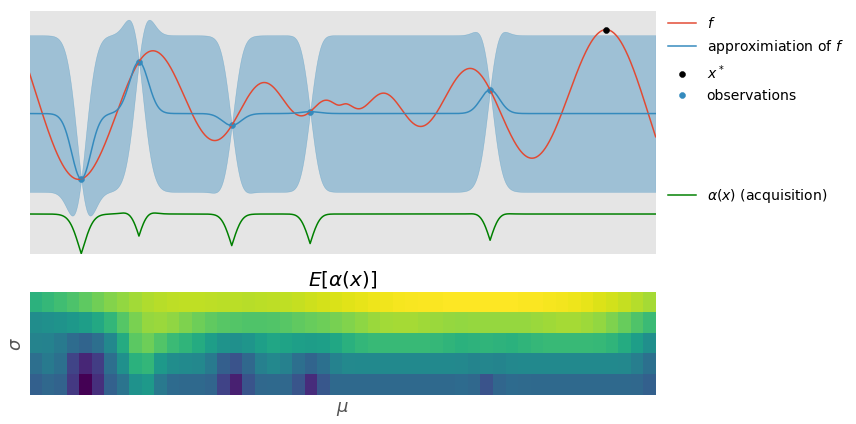

In [105]:
n = 5
ss = 5
scipy.random.seed(3)
xi = np.random.choice(np.arange(pn-100), n, replace=False)
# x = o.sample_space(pn)[np.random.choice(np.arange(pn), n, replace=False)]
mx = x[xi]
y = o(mx)[:, None]

builder = modeler.Modeler(o, noiseless=True, kernel=GPy.kern.RBF(x.shape[1], ARD=False))

m = builder.build(mx, y, resample=2)

mu, var = m.predict(builder.transform(x))
mu = mu[:, 0]
var = var[:, 0]

nmu = mu * y.std() + y.mean()
nvar = var * y.var()

a = aquisition.SBUCB_LocalPenalty(sample_size=ss)
a._precompute(m, builder, x, mu, var, False, n, pn)
alpha = mu + a.beta(mx.shape[0], x.shape[0]) * np.sqrt(var)

fig = plt.figure(figsize=(12, 6))

ax = plt.subplot2grid((3, 2), (0, 0), colspan=2, rowspan=2)
plt.plot(x, f, zorder=1, label="$f$")
plt.scatter(o.optimum, o(o.optimum), marker="o", c="k", zorder=2, label='$x^*$')
plt.yticks([])

plt.plot(x, nmu, label="approximiation of $f$")
plt.fill_between(x[:,0], nmu-2*np.sqrt(nvar), nmu+2*np.sqrt(nvar), alpha=.4, color="C1")
plt.scatter(mx, y, c="C1", label="observations")

plt.ylim(f.min() - .5*(f.max()-f.min()))

axt = plt.twinx()
plt.plot(x[:,0], alpha, color='green', label=r"$\alpha(x)$ (acquisition)")
plt.yticks([])
plt.grid(False)

plt.ylim(alpha.min()-.1, alpha.max() + 5*(alpha.max()-alpha.min()))

plt.xlim(-500, 500)
plt.xticks([])

a = aquisition.SBUCB_LocalPenalty(sample_size=ss)
a._precompute(m, builder, x, mu, var, False, n, pn)
acq = a.compute(m, builder, x, b, False, n, pn)

ax.legend(loc='upper left', bbox_to_anchor= (1.01, 1), ncol=1, 
                borderaxespad=0, frameon=False)
axt.legend(loc='upper left', bbox_to_anchor= (1.01, .3), ncol=1, 
                borderaxespad=0, frameon=False)

plt.subplot2grid((3, 2), (2, 0), colspan=2, rowspan=1)
plt.imshow(acq.reshape((50, 5)).T, origin="bottom", aspect="auto")
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.ylabel("$\sigma$") 
plt.xlabel("$\mu$")
plt.title(r"$E[\alpha(x)]$")

plt.tight_layout()
plt.savefig("figures/ssbo-early-batch-acquistion-anim1.pdf", bbox_inches="tight")

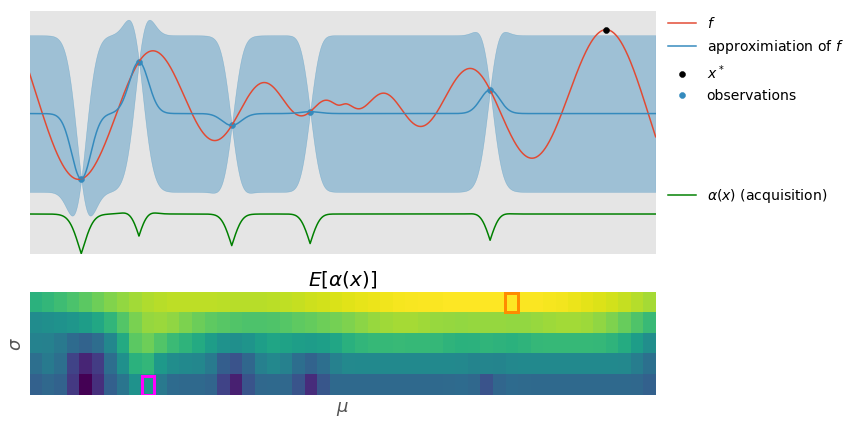

In [106]:
builder = modeler.Modeler(o, noiseless=True, kernel=GPy.kern.RBF(x.shape[1], ARD=False))

m = builder.build(mx, y, resample=2)

mu, var = m.predict(builder.transform(x))
mu = mu[:, 0]
var = var[:, 0]

nmu = mu * y.std() + y.mean()
nvar = var * y.var()

a = aquisition.SBUCB_LocalPenalty(sample_size=ss)
a._precompute(m, builder, x, mu, var, False, n, pn)
alpha = mu + a.beta(mx.shape[0], x.shape[0]) * np.sqrt(var)

fig = plt.figure(figsize=(12, 6))

ax = plt.subplot2grid((3, 2), (0, 0), colspan=2, rowspan=2)
plt.plot(x, f, zorder=1, label="$f$")
plt.scatter(o.optimum, o(o.optimum), marker="o", c="k", zorder=2, label='$x^*$')
plt.yticks([])

plt.plot(x, nmu, label="approximiation of $f$")
plt.fill_between(x[:,0], nmu-2*np.sqrt(nvar), nmu+2*np.sqrt(nvar), alpha=.4, color="C1")
plt.scatter(mx, y, c="C1", label="observations")

plt.ylim(f.min() - .5*(f.max()-f.min()))

axt = plt.twinx()
plt.plot(x[:,0], alpha, color='green', label=r"$\alpha(x)$ (acquisition)")
plt.yticks([])
plt.grid(False)

plt.ylim(alpha.min()-.1, alpha.max() + 5*(alpha.max()-alpha.min()))

plt.xlim(-500, 500)
plt.xticks([])

a = aquisition.SBUCB_LocalPenalty(sample_size=ss)
a._precompute(m, builder, x, mu, var, False, n, pn)
acq = a.compute(m, builder, x, b, False, n, pn)

ax.legend(loc='upper left', bbox_to_anchor= (1.01, 1), ncol=1, 
                borderaxespad=0, frameon=False)
axt.legend(loc='upper left', bbox_to_anchor= (1.01, .3), ncol=1, 
                borderaxespad=0, frameon=False)

ax = plt.subplot2grid((3, 2), (2, 0), colspan=2, rowspan=1)
plt.imshow(acq.reshape((50, 5)).T, origin="bottom", aspect="auto")

ax.add_patch(Rectangle((37.5, 3.5), 1, .9, edgecolor="darkorange", linewidth=3, facecolor="none"))
ax.add_patch(Rectangle((8.5, -.5), 1, .9, edgecolor="magenta", linewidth=3, facecolor="none"))

plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.ylabel("$\sigma$") 
plt.xlabel("$\mu$")
plt.title(r"$E[\alpha(x)]$")

plt.tight_layout()
plt.savefig("figures/ssbo-early-batch-acquistion-anim2.pdf", bbox_inches="tight")

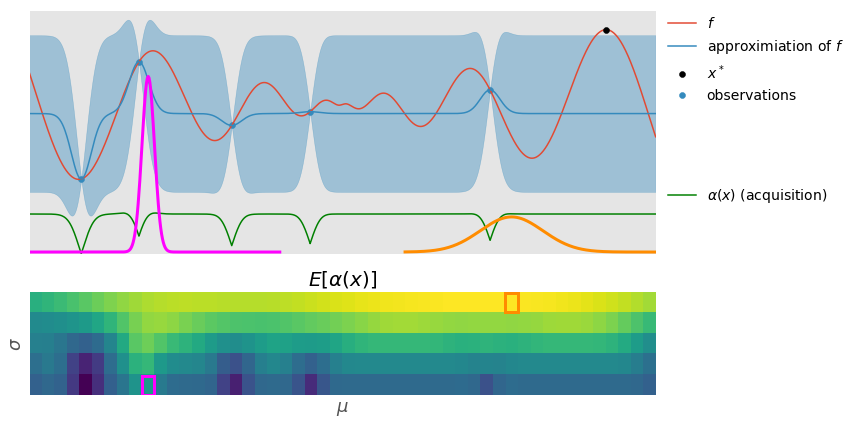

In [107]:
builder = modeler.Modeler(o, noiseless=True, kernel=GPy.kern.RBF(x.shape[1], ARD=False))

m = builder.build(mx, y, resample=2)

mu, var = m.predict(builder.transform(x))
mu = mu[:, 0]
var = var[:, 0]

nmu = mu * y.std() + y.mean()
nvar = var * y.var()

a = aquisition.SBUCB_LocalPenalty(sample_size=ss)
a._precompute(m, builder, x, mu, var, False, n, pn)
alpha = mu + a.beta(mx.shape[0], x.shape[0]) * np.sqrt(var)

fig = plt.figure(figsize=(12, 6))

ax = plt.subplot2grid((3, 2), (0, 0), colspan=2, rowspan=2)
plt.plot(x, f, zorder=1, label="$f$")
plt.scatter(o.optimum, o(o.optimum), marker="o", c="k", zorder=2, label='$x^*$')
plt.yticks([])

plt.plot(x, nmu, label="approximiation of $f$")
plt.fill_between(x[:,0], nmu-2*np.sqrt(nvar), nmu+2*np.sqrt(nvar), alpha=.4, color="C1")
plt.scatter(mx, y, c="C1", label="observations")

plt.ylim(f.min() - .5*(f.max()-f.min()))

axt = plt.twinx()
plt.plot(x[:,0], alpha, color='green', label=r"$\alpha(x)$ (acquisition)")
plt.yticks([])
plt.grid(False)

plt.ylim(alpha.min()-.1, alpha.max() + 5*(alpha.max()-alpha.min()))

plt.xlim(-500, 500)
plt.xticks([])

a = aquisition.SBUCB_LocalPenalty(sample_size=ss)
a._precompute(m, builder, x, mu, var, False, n, pn)
acq = a.compute(m, builder, x, b, False, n, pn)

ax.legend(loc='upper left', bbox_to_anchor= (1.01, 1), ncol=1, 
                borderaxespad=0, frameon=False)
axt.legend(loc='upper left', bbox_to_anchor= (1.01, .3), ncol=1, 
                borderaxespad=0, frameon=False)

# distributions
plt.twinx()
plt.yticks([])
plt.grid(False)
#plt.ylim(alpha.min()-.1, alpha.max() + 3*(alpha.max()-alpha.min()))
plt.ylim(-.0005, .055)
plt.xlim(-500, 500)
plt.xticks([])

z = np.linspace(100, 500, 300)
plt.plot(z, scipy.stats.norm(270, 50).pdf(z), color="darkorange", lw=3)

z = np.linspace(-500, -100, 300)
plt.plot(z, scipy.stats.norm(-310, 10).pdf(z), color="magenta", lw=3)

# ssbo acquisition
ax = plt.subplot2grid((3, 2), (2, 0), colspan=2, rowspan=1)
plt.imshow(acq.reshape((50, 5)).T, origin="bottom", aspect="auto")

ax.add_patch(Rectangle((37.5, 3.5), 1, .9, edgecolor="darkorange", linewidth=3, facecolor="none"))
ax.add_patch(Rectangle((8.5, -.5), 1, .9, edgecolor="magenta", linewidth=3, facecolor="none"))

plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.ylabel("$\sigma$") 
plt.xlabel("$\mu$")
plt.title(r"$E[\alpha(x)]$")

plt.tight_layout()
plt.savefig("figures/ssbo-early-batch-acquistion-anim3.pdf", bbox_inches="tight")

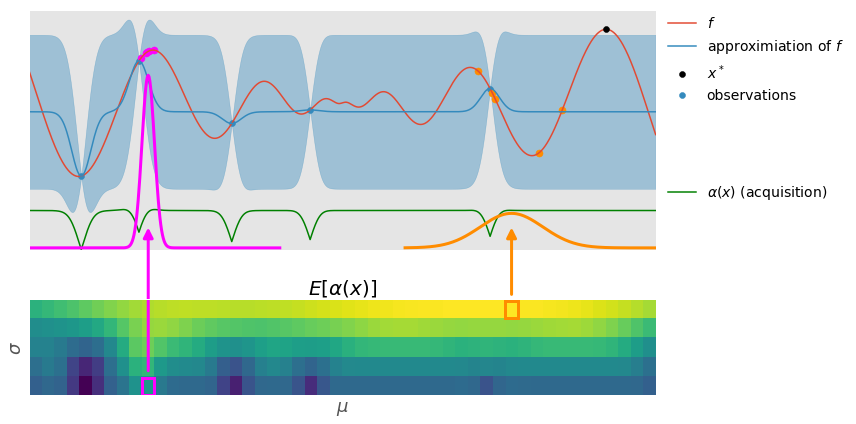

In [130]:
builder = modeler.Modeler(o, noiseless=True, kernel=GPy.kern.RBF(x.shape[1], ARD=False))

m = builder.build(mx, y, resample=2)

mu, var = m.predict(builder.transform(x))
mu = mu[:, 0]
var = var[:, 0]

nmu = mu * y.std() + y.mean()
nvar = var * y.var()

a = aquisition.SBUCB_LocalPenalty(sample_size=ss)
a._precompute(m, builder, x, mu, var, False, n, pn)
alpha = mu + a.beta(mx.shape[0], x.shape[0]) * np.sqrt(var)

fig = plt.figure(figsize=(12, 6))

ax = plt.subplot2grid((3, 2), (0, 0), colspan=2, rowspan=2)
plt.plot(x, f, zorder=1, label="$f$")
plt.scatter(o.optimum, o(o.optimum), marker="o", c="k", zorder=2, label='$x^*$')
plt.yticks([])

plt.plot(x, nmu, label="approximiation of $f$")
plt.fill_between(x[:,0], nmu-2*np.sqrt(nvar), nmu+2*np.sqrt(nvar), alpha=.4, color="C1")
plt.scatter(mx, y, c="C1", label="observations")

plt.ylim(f.min() - .5*(f.max()-f.min()))

np.random.seed(1)
tmp = scipy.stats.norm(270, 50).rvs(5)
plt.scatter(tmp, o(tmp[:, None]), c="darkorange", s=50)
tmp2 = scipy.stats.norm(-310, 5).rvs(5)
plt.scatter(tmp2, o(tmp2[:, None]), c="magenta", s=50)

# alpha
axt = plt.twinx()
plt.plot(x[:,0], alpha, color='green', label=r"$\alpha(x)$ (acquisition)")
plt.yticks([])
plt.grid(False)

plt.ylim(alpha.min()-.1, alpha.max() + 5*(alpha.max()-alpha.min()))

plt.xlim(-500, 500)
plt.xticks([])

a = aquisition.SBUCB_LocalPenalty(sample_size=ss)
a._precompute(m, builder, x, mu, var, False, n, pn)
acq = a.compute(m, builder, x, b, False, n, pn)

ax.legend(loc='upper left', bbox_to_anchor= (1.01, 1), ncol=1, 
                borderaxespad=0, frameon=False)
axt.legend(loc='upper left', bbox_to_anchor= (1.01, .3), ncol=1, 
                borderaxespad=0, frameon=False)

# distributions
plt.twinx()
plt.yticks([])
plt.grid(False)
#plt.ylim(alpha.min()-.1, alpha.max() + 3*(alpha.max()-alpha.min()))
plt.ylim(-.0005, .055)
plt.xlim(-500, 500)
plt.xticks([])

z = np.linspace(100, 500, 300)
plt.plot(z, scipy.stats.norm(270, 50).pdf(z), color="darkorange", lw=3)
z = np.linspace(-500, -100, 300)
plt.plot(z, scipy.stats.norm(-310, 10).pdf(z), color="magenta", lw=3)

# ssbo acquisition
ax2 = plt.subplot2grid((3, 2), (2, 0), colspan=2, rowspan=1)
plt.imshow(acq.reshape((50, 5)).T, origin="bottom", aspect="auto")

ax2.add_patch(Rectangle((37.5, 3.5), 1, .9, edgecolor="darkorange", linewidth=3, facecolor="none"))
ax2.add_patch(Rectangle((8.5, -.5), 1, .9, edgecolor="magenta", linewidth=3, facecolor="none"))

plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.ylabel("$\sigma$") 
plt.xlabel("$\mu$")
plt.title(r"$E[\alpha(x)]$")

# annotate distribution across plots
conn = ConnectionPatch((38, 4.5), (270, -1100), "data", axesA=ax2, axesB=ax, color="darkorange", lw=3, arrowstyle="-|>", shrinkA=5, shrinkB=5, mutation_scale=20)
ax2.add_artist(conn)
conn = ConnectionPatch((9, 0.5), (-310, -1100), "data", axesA=ax2, axesB=ax, color="magenta", lw=3, arrowstyle="-|>", shrinkA=5, shrinkB=5, mutation_scale=20)
ax2.add_artist(conn)

plt.tight_layout()
plt.savefig("figures/ssbo-early-batch-acquistion-anim4.pdf", bbox_inches="tight", dpi=300)

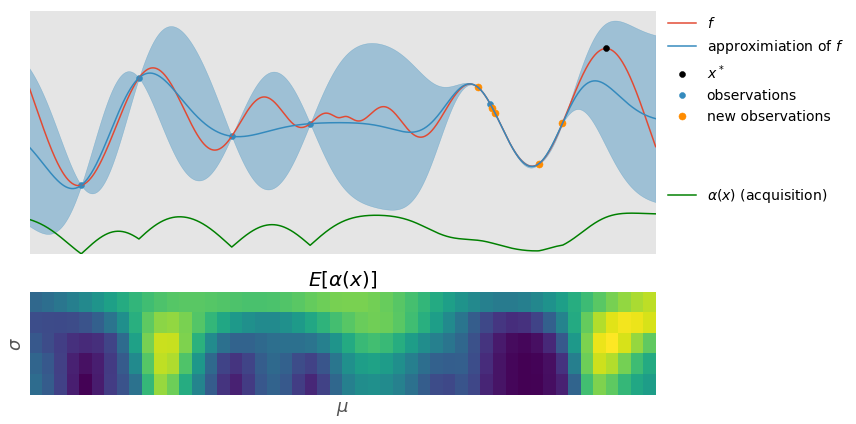

In [103]:
mx = np.concatenate((mx, tmp[:, None]))
y = o(mx)
builder = modeler.Modeler(o, noiseless=True, kernel=GPy.kern.RBF(x.shape[1], ARD=False))

m = builder.build(mx, y, resample=2)

mu, var = m.predict(builder.transform(x))
mu = mu[:, 0]
var = var[:, 0]

nmu = mu * y.std() + y.mean()
nvar = var * y.var()

a = aquisition.SBUCB_LocalPenalty(sample_size=ss)
a._precompute(m, builder, x, mu, var, False, n, pn)
alpha = mu + a.beta(mx.shape[0], x.shape[0]) * np.sqrt(var)

fig = plt.figure(figsize=(12, 6))

ax = plt.subplot2grid((3, 2), (0, 0), colspan=2, rowspan=2)
plt.plot(x, f, zorder=1, label="$f$")
plt.scatter(o.optimum, o(o.optimum), marker="o", c="k", zorder=2, label='$x^*$')
plt.yticks([])

plt.plot(x, nmu, label="approximiation of $f$")
plt.fill_between(x[:,0], nmu-2*np.sqrt(nvar), nmu+2*np.sqrt(nvar), alpha=.4, color="C1")
plt.scatter(mx[:-5,:], y[:-5], c="C1", label="observations")
plt.scatter(mx[-5:,:], y[-5:], c="darkorange", label="new observations", s=50)

plt.ylim(f.min() - .5*(f.max()-f.min()))

axt = plt.twinx()
plt.plot(x[:,0], alpha, color='green', label=r"$\alpha(x)$ (acquisition)")
plt.yticks([])
plt.grid(False)

plt.ylim(alpha.min()-.1, alpha.max() + 5*(alpha.max()-alpha.min()))

plt.xlim(-500, 500)
plt.xticks([])

a = aquisition.SBUCB_LocalPenalty(sample_size=ss)
a._precompute(m, builder, x, mu, var, False, n, pn)
acq = a.compute(m, builder, x, b, False, n, pn)

ax.legend(loc='upper left', bbox_to_anchor= (1.01, 1), ncol=1, 
                borderaxespad=0, frameon=False)
axt.legend(loc='upper left', bbox_to_anchor= (1.01, .3), ncol=1, 
                borderaxespad=0, frameon=False)

plt.subplot2grid((3, 2), (2, 0), colspan=2, rowspan=1)
plt.imshow(acq.reshape((50, 5)).T, origin="bottom", aspect="auto")
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.ylabel("$\sigma$") 
plt.xlabel("$\mu$")
plt.title(r"$E[\alpha(x)]$")

plt.tight_layout()
plt.savefig("figures/ssbo-early-batch-acquistion-anim5.pdf", bbox_inches="tight")

## mid

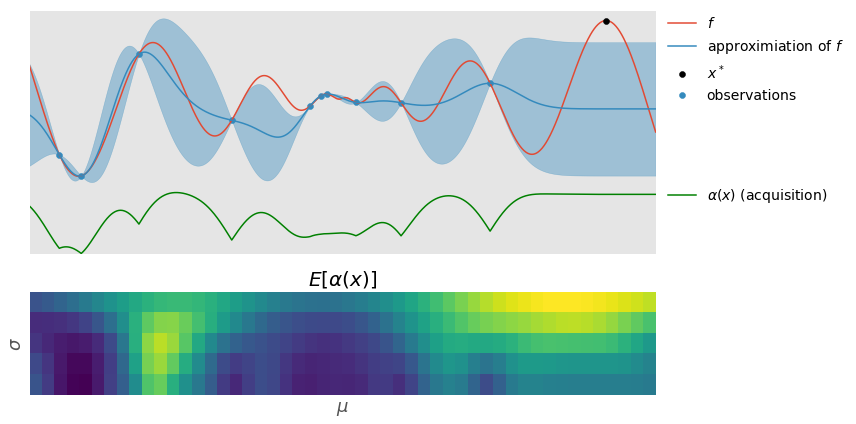

In [52]:
n = 10
ss = 5
scipy.random.seed(3)
xi = np.random.choice(np.arange(pn-100), n, replace=False)
# x = o.sample_space(pn)[np.random.choice(np.arange(pn), n, replace=False)]
mx = x[xi]
y = o(mx)[:, None]

builder = modeler.Modeler(o, noiseless=True, kernel=GPy.kern.RBF(x.shape[1], ARD=False))

m = builder.build(mx, y, resample=2)

mu, var = m.predict(builder.transform(x))
mu = mu[:, 0]
var = var[:, 0]

nmu = mu * y.std() + y.mean()
nvar = var * y.var()

a = aquisition.SBUCB_LocalPenalty(sample_size=ss)
a._precompute(m, builder, x, mu, var, False, n, pn)
alpha = mu + a.beta(mx.shape[0], x.shape[0]) * np.sqrt(var)

fig = plt.figure(figsize=(12, 6))

ax = plt.subplot2grid((3, 2), (0, 0), colspan=2, rowspan=2)
plt.plot(x, f, zorder=1, label="$f$")
plt.scatter(o.optimum, o(o.optimum), marker="o", c="k", zorder=2, label='$x^*$')
plt.yticks([])

plt.plot(x, nmu, label="approximiation of $f$")
plt.fill_between(x[:,0], nmu-2*np.sqrt(nvar), nmu+2*np.sqrt(nvar), alpha=.4, color="C1")
plt.scatter(mx, y, c="C1", label="observations")

plt.ylim(f.min() - .5*(f.max()-f.min()))

axt = plt.twinx()
plt.plot(x[:,0], alpha, color='green', label=r"$\alpha(x)$ (acquisition)")
plt.yticks([])
plt.grid(False)

plt.ylim(alpha.min()-.1, alpha.max() + 3*(alpha.max()-alpha.min()))

plt.xlim(-500, 500)
plt.xticks([])

a = aquisition.SBUCB_LocalPenalty(sample_size=ss)
a._precompute(m, builder, x, mu, var, False, n, pn)
acq = a.compute(m, builder, x, b, False, n, pn)

ax.legend(loc='upper left', bbox_to_anchor= (1.01, 1), ncol=1, 
                borderaxespad=0, frameon=False)
axt.legend(loc='upper left', bbox_to_anchor= (1.01, .3), ncol=1, 
                borderaxespad=0, frameon=False)

plt.subplot2grid((3, 2), (2, 0), colspan=2, rowspan=1)
plt.imshow(acq.reshape((50, 5)).T, origin="bottom", aspect="auto")
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.ylabel("$\sigma$") 
plt.xlabel("$\mu$")
plt.title(r"$E[\alpha(x)]$")

plt.tight_layout()
plt.savefig("figures/ssbo-mid-batch-acquistion-anim1.pdf", bbox_inches="tight")

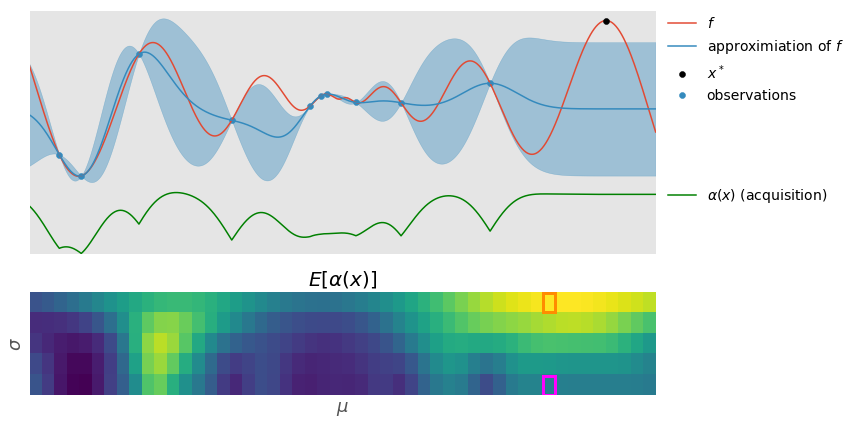

In [49]:
builder = modeler.Modeler(o, noiseless=True, kernel=GPy.kern.RBF(x.shape[1], ARD=False))

m = builder.build(mx, y, resample=2)

mu, var = m.predict(builder.transform(x))
mu = mu[:, 0]
var = var[:, 0]

nmu = mu * y.std() + y.mean()
nvar = var * y.var()

a = aquisition.SBUCB_LocalPenalty(sample_size=ss)
a._precompute(m, builder, x, mu, var, False, n, pn)
alpha = mu + a.beta(mx.shape[0], x.shape[0]) * np.sqrt(var)

fig = plt.figure(figsize=(12, 6))

ax = plt.subplot2grid((3, 2), (0, 0), colspan=2, rowspan=2)
plt.plot(x, f, zorder=1, label="$f$")
plt.scatter(o.optimum, o(o.optimum), marker="o", c="k", zorder=2, label='$x^*$')
plt.yticks([])

plt.plot(x, nmu, label="approximiation of $f$")
plt.fill_between(x[:,0], nmu-2*np.sqrt(nvar), nmu+2*np.sqrt(nvar), alpha=.4, color="C1")
plt.scatter(mx, y, c="C1", label="observations")

plt.ylim(f.min() - .5*(f.max()-f.min()))

axt = plt.twinx()
plt.plot(x[:,0], alpha, color='green', label=r"$\alpha(x)$ (acquisition)")
plt.yticks([])
plt.grid(False)

plt.ylim(alpha.min()-.1, alpha.max() + 3*(alpha.max()-alpha.min()))

plt.xlim(-500, 500)
plt.xticks([])

a = aquisition.SBUCB_LocalPenalty(sample_size=ss)
a._precompute(m, builder, x, mu, var, False, n, pn)
acq = a.compute(m, builder, x, b, False, n, pn)

ax.legend(loc='upper left', bbox_to_anchor= (1.01, 1), ncol=1, 
                borderaxespad=0, frameon=False)
axt.legend(loc='upper left', bbox_to_anchor= (1.01, .3), ncol=1, 
                borderaxespad=0, frameon=False)

ax = plt.subplot2grid((3, 2), (2, 0), colspan=2, rowspan=1)
plt.imshow(acq.reshape((50, 5)).T, origin="bottom", aspect="auto")

ax.add_patch(Rectangle((40.5, 3.5), 1, .9, edgecolor="darkorange", linewidth=3, facecolor="none"))
ax.add_patch(Rectangle((40.5, -.5), 1, .9, edgecolor="magenta", linewidth=3, facecolor="none"))

plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.ylabel("$\sigma$") 
plt.xlabel("$\mu$")
plt.title(r"$E[\alpha(x)]$")

plt.tight_layout()
plt.savefig("figures/ssbo-mid-batch-acquistion-anim2.pdf", bbox_inches="tight")

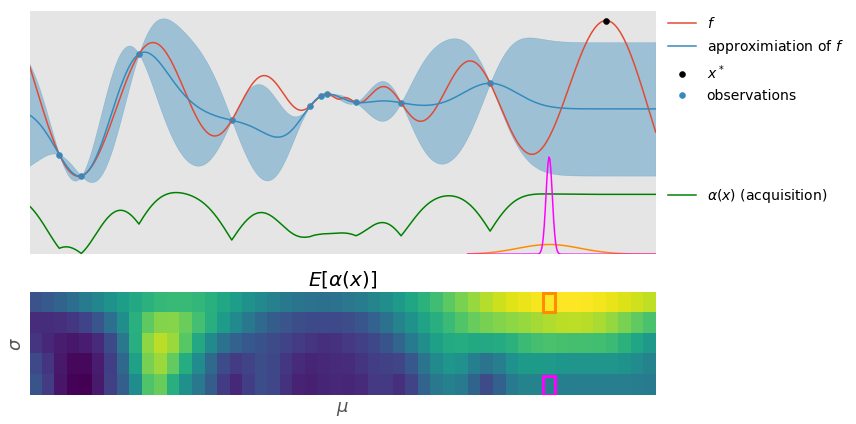

In [50]:
builder = modeler.Modeler(o, noiseless=True, kernel=GPy.kern.RBF(x.shape[1], ARD=False))

m = builder.build(mx, y, resample=2)

mu, var = m.predict(builder.transform(x))
mu = mu[:, 0]
var = var[:, 0]

nmu = mu * y.std() + y.mean()
nvar = var * y.var()

a = aquisition.SBUCB_LocalPenalty(sample_size=ss)
a._precompute(m, builder, x, mu, var, False, n, pn)
alpha = mu + a.beta(mx.shape[0], x.shape[0]) * np.sqrt(var)

fig = plt.figure(figsize=(12, 6))

ax = plt.subplot2grid((3, 2), (0, 0), colspan=2, rowspan=2)
plt.plot(x, f, zorder=1, label="$f$")
plt.scatter(o.optimum, o(o.optimum), marker="o", c="k", zorder=2, label='$x^*$')
plt.yticks([])

plt.plot(x, nmu, label="approximiation of $f$")
plt.fill_between(x[:,0], nmu-2*np.sqrt(nvar), nmu+2*np.sqrt(nvar), alpha=.4, color="C1")
plt.scatter(mx, y, c="C1", label="observations")

plt.ylim(f.min() - .5*(f.max()-f.min()))

axt = plt.twinx()
plt.plot(x[:,0], alpha, color='green', label=r"$\alpha(x)$ (acquisition)")
plt.yticks([])
plt.grid(False)

plt.ylim(alpha.min()-.1, alpha.max() + 3*(alpha.max()-alpha.min()))

plt.xlim(-500, 500)
plt.xticks([])

a = aquisition.SBUCB_LocalPenalty(sample_size=ss)
a._precompute(m, builder, x, mu, var, False, n, pn)
acq = a.compute(m, builder, x, b, False, n, pn)

ax.legend(loc='upper left', bbox_to_anchor= (1.01, 1), ncol=1, 
                borderaxespad=0, frameon=False)
axt.legend(loc='upper left', bbox_to_anchor= (1.01, .3), ncol=1, 
                borderaxespad=0, frameon=False)

# distributions
plt.twinx()
plt.yticks([])
plt.grid(False)
#plt.ylim(alpha.min()-.1, alpha.max() + 3*(alpha.max()-alpha.min()))
plt.ylim(0, .2)
plt.xlim(-500, 500)
plt.xticks([])

z = np.linspace(200, 500, 200)
plt.plot(z, scipy.stats.norm(330, 50).pdf(z), color="darkorange")
plt.plot(z, scipy.stats.norm(330, 5).pdf(z), color="magenta")

# ssbo acquisition
ax = plt.subplot2grid((3, 2), (2, 0), colspan=2, rowspan=1)
plt.imshow(acq.reshape((50, 5)).T, origin="bottom", aspect="auto")

ax.add_patch(Rectangle((40.5, 3.5), 1, .9, edgecolor="darkorange", linewidth=3, facecolor="none"))
ax.add_patch(Rectangle((40.5, -.5), 1, .9, edgecolor="magenta", linewidth=3, facecolor="none"))

plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.ylabel("$\sigma$") 
plt.xlabel("$\mu$")
plt.title(r"$E[\alpha(x)]$")

plt.tight_layout()
plt.savefig("figures/ssbo-mid-batch-acquistion-anim3.pdf", bbox_inches="tight")

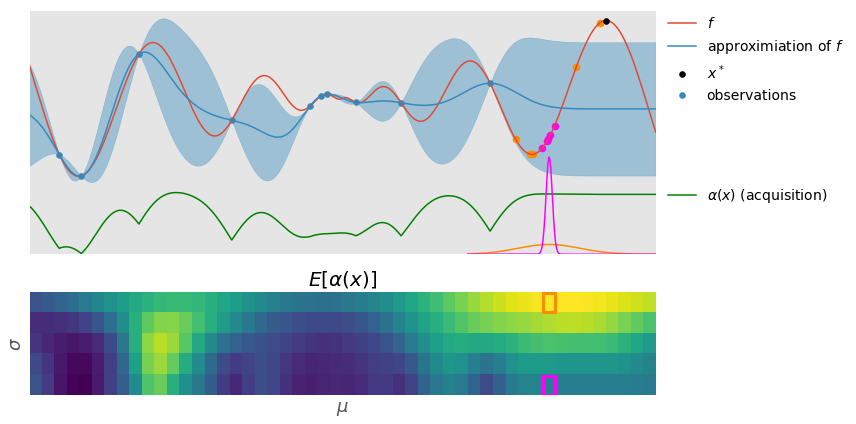

In [51]:
builder = modeler.Modeler(o, noiseless=True, kernel=GPy.kern.RBF(x.shape[1], ARD=False))

m = builder.build(mx, y, resample=2)

mu, var = m.predict(builder.transform(x))
mu = mu[:, 0]
var = var[:, 0]

nmu = mu * y.std() + y.mean()
nvar = var * y.var()

a = aquisition.SBUCB_LocalPenalty(sample_size=ss)
a._precompute(m, builder, x, mu, var, False, n, pn)
alpha = mu + a.beta(mx.shape[0], x.shape[0]) * np.sqrt(var)

fig = plt.figure(figsize=(12, 6))

ax = plt.subplot2grid((3, 2), (0, 0), colspan=2, rowspan=2)
plt.plot(x, f, zorder=1, label="$f$")
plt.scatter(o.optimum, o(o.optimum), marker="o", c="k", zorder=2, label='$x^*$')
plt.yticks([])

plt.plot(x, nmu, label="approximiation of $f$")
plt.fill_between(x[:,0], nmu-2*np.sqrt(nvar), nmu+2*np.sqrt(nvar), alpha=.4, color="C1")
plt.scatter(mx, y, c="C1", label="observations")

plt.ylim(f.min() - .5*(f.max()-f.min()))

np.random.seed(1)
tmp = scipy.stats.norm(330, 50).rvs(5)
plt.scatter(tmp, o(tmp[:, None]), c="darkorange", s=50)
tmp = scipy.stats.norm(330, 5).rvs(5)
plt.scatter(tmp, o(tmp[:, None]), c="magenta", s=50)

# alpha
axt = plt.twinx()
plt.plot(x[:,0], alpha, color='green', label=r"$\alpha(x)$ (acquisition)")
plt.yticks([])
plt.grid(False)

plt.ylim(alpha.min()-.1, alpha.max() + 3*(alpha.max()-alpha.min()))

plt.xlim(-500, 500)
plt.xticks([])

a = aquisition.SBUCB_LocalPenalty(sample_size=ss)
a._precompute(m, builder, x, mu, var, False, n, pn)
acq = a.compute(m, builder, x, b, False, n, pn)

ax.legend(loc='upper left', bbox_to_anchor= (1.01, 1), ncol=1, 
                borderaxespad=0, frameon=False)
axt.legend(loc='upper left', bbox_to_anchor= (1.01, .3), ncol=1, 
                borderaxespad=0, frameon=False)

# distributions
plt.twinx()
plt.yticks([])
plt.grid(False)
#plt.ylim(alpha.min()-.1, alpha.max() + 3*(alpha.max()-alpha.min()))
plt.ylim(0, .2)
plt.xlim(-500, 500)
plt.xticks([])

z = np.linspace(200, 500, 200)
plt.plot(z, scipy.stats.norm(330, 50).pdf(z), color="darkorange")
plt.plot(z, scipy.stats.norm(330, 5).pdf(z), color="magenta")

# ssbo acquisition
ax = plt.subplot2grid((3, 2), (2, 0), colspan=2, rowspan=1)
plt.imshow(acq.reshape((50, 5)).T, origin="bottom", aspect="auto")

ax.add_patch(Rectangle((40.5, 3.5), 1, .9, edgecolor="darkorange", linewidth=3, facecolor="none"))
ax.add_patch(Rectangle((40.5, -.5), 1, .9, edgecolor="magenta", linewidth=3, facecolor="none"))

plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.ylabel("$\sigma$") 
plt.xlabel("$\mu$")
plt.title(r"$E[\alpha(x)]$")

plt.tight_layout()
plt.savefig("figures/ssbo-mid-batch-acquistion-anim4.pdf", bbox_inches="tight")